## 불균형 데이터와 설명 가능성을 고려한 게임 재화 어뷰징 검출을 위한 지도, 자기지도 및 준지도 학습 모델 - Model
- **Problem**

현재 특정 온라인 RPG 게임에서는 골드를 부당하게 얻는 어뷰저를 탐지하고 제재하는 업무를 수행하고 있습니다.

이미 일부 유저에 대해서는 정상적인 플레이어 여부를 확인했지만, 아직 어뷰저 여부를 판별할 수 없는 다수의 유저가 남아 있습니다.

이러한 상황에서 모든 유저를 개별적으로 조사하는 것은 비효율적이므로 데이터 분석을 통해 어뷰저를 자동으로 식별하는 로직을 개발하고자 합니다.

- **Process**
1. Preparation
2. AutoEncoder
3. Supervised learning Model
4. Label Propagation
6. Self-supervised learning Model
5. Semi-supervised learning Model
6. Feature importance
7. Prediction


### Data

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [132]:
# Import Python Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
np.random.seed(1)

In [70]:
# 데이터 가져오기
data = pd.read_csv('/content/gdrive/My Drive/data/data.csv')
data.head()

,newID,char_jobcode,char_level,logging_timestamp,charStatA,charStatB,charStatC,charStatD,charStatE,charStatF,...,actionSessionAmountH,actionSessionAmountI,actionSessionAmountJ,actionSessionAmountK,actionSessionAmountL,actionSessionAmountM,actionSessionAmountN,tradeSessionAmountD,tradeSessionAmountE,isAbuser
0,0,0,10,2022-06-26 08:59:04,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,-1
1,0,0,31,2022-06-26 09:29:06,0,0,0,0,2,0,...,0,0,0,2,146,0,106,0,0,-1
2,0,0,40,2022-06-26 09:59:13,0,0,0,0,2,0,...,0,0,0,2,229,0,172,0,0,-1
3,0,0,61,2022-06-26 10:29:14,0,0,0,0,6,0,...,1,2,0,2,583,0,615,0,0,-1
4,0,0,61,2022-06-27 07:51:56,0,0,0,0,6,0,...,0,1,0,17,1,0,0,0,0,-1


### 1. Preparation

In [71]:
# 불필요한 column 제거;
data = data.drop(['logging_timestamp', 'tradeSessionAmountB', 'actionSessionAmountM', 'tradeSessionAmountC', 'charSessionAmountB', 'accountMetaAmountA', 'socialBooleanB', 'tradeSessionAmountE'], axis=1)

In [72]:
# 어뷰저 여부에 따른 데이터셋 분리
non_abuser = data[data['isAbuser'] == 0]
abuser = data[data['isAbuser'] == 1]
known = data[data['isAbuser'] != -1]
unknown = data[data['isAbuser'] == -1]

In [ ]:
# 데이터 로그 변환 by column
def log_transform(data, col):
  for colname in col:
    ncal = data.filter(like=colname).columns
    for ncolname in ncal:
      if (data[ncolname] == 1.0).all():
        data[ncolname + '_log'] = np.log(data[ncolname]+1)
      else:
        data[ncolname + '_log'] = np.log(data[ncolname])
  data.info()

  # log_transform(known, ['charStatB','charStatC','charStatD','charStatE','charStatF','charStatG','actionSessionAmountA','actionSessionAmountB','actionSessionAmountL','actionSessionAmountN'])

In [73]:
# 정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scl_columns = ['charStatB','charStatC','charStatD','charStatE','charStatF','charStatG','actionSessionAmountA','actionSessionAmountB','actionSessionAmountL','actionSessionAmountN']
known[scl_columns] = scaler.fit_transform(known[scl_columns])

### 2. AutoEncoders : Latent Representation Extraction

In [19]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense
from keras import regularizers

import seaborn as sns

In [74]:
X = known.drop(['isAbuser'], axis = 1).values
Y = known['isAbuser'].values

In [75]:
# input layer
input_layer = Input(shape=(X.shape[1],))

# encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

# decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

# output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

In [76]:
# Autoencoder 모델 구축
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [77]:
x = known.drop(['isAbuser'], axis = 1)
y = known['isAbuser'].values

test_x = unknown.drop(['isAbuser'], axis = 1)

x_scale = MinMaxScaler().fit_transform(x.values)
test_x_scale = MinMaxScaler().fit_transform(test_x.values)

x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

In [78]:
autoencoder.fit(x_norm[0:2000], x_norm[0:2000],
                batch_size = 256, epochs = 10,
                shuffle = True, validation_split = 0.20);

Epoch 1/10
7/7 [==============================] - 1s 32ms/step - loss: 0.0407 - val_loss: 0.0443
Epoch 2/10
7/7 [==============================] - 0s 14ms/step - loss: 0.0407 - val_loss: 0.0443
Epoch 3/10
7/7 [==============================] - 0s 15ms/step - loss: 0.0407 - val_loss: 0.0443
Epoch 4/10
7/7 [==============================] - 0s 13ms/step - loss: 0.0407 - val_loss: 0.0443
Epoch 5/10
7/7 [==============================] - 0s 13ms/step - loss: 0.0407 - val_loss: 0.0442
Epoch 6/10
7/7 [==============================] - 0s 13ms/step - loss: 0.0406 - val_loss: 0.0442
Epoch 7/10
7/7 [==============================] - 0s 16ms/step - loss: 0.0406 - val_loss: 0.0442
Epoch 8/10
7/7 [==============================] - 0s 14ms/step - loss: 0.0406 - val_loss: 0.0442
Epoch 9/10
7/7 [==============================] - 0s 12ms/step - loss: 0.0406 - val_loss: 0.0441
Epoch 10/10
7/7 [==============================] - 0s 12ms/step - loss: 0.0406 - val_loss: 0.0441


In [79]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [80]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

293/293 [==============================] - 0s 1ms/step


In [81]:
# Representation 추출
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

In [28]:
# Train/Test Dataset Split
train_X, test_X, train_y, test_y = train_test_split(rep_x, rep_y, test_size=0.20)

### 3. Supervised learning Model

In [29]:
! pip install scikit-plot

In [65]:
import sklearn.svm as svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_predict, GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, recall_score, precision_score, auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.semi_supervised import LabelPropagation, LabelSpreading
import scikitplot as skplt

import torch

In [37]:
def plot_conf_mx(cm, ax):
    sns.heatmap(data=cm,
                annot=True,
                cmap='Blues',
                ax=ax)

    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Abuser', 'NonAbuser'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.25, 1.25])
    ax.set_yticklabels(['Abuser', 'NonAbuser']);

def plot_learning_curve(estimator,
                        X,
                        y,
                        ax,
                        cv=None,
                        train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes,
                    train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std,
                    alpha=0.1,
                    color='dodgerblue')
    ax.fill_between(train_sizes,
                    test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std,
                    alpha=0.1,
                    color='darkorange')

    ax.plot(train_sizes,
            train_scores_mean,
            color='dodgerblue',
            marker='o',
            linestyle='-',
            label='Training Score')
    ax.plot(train_sizes,
            test_scores_mean,
            color='darkorange',
            marker='o',
            linestyle='-',
            label='Cross-validation Score')

    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Score')
    ax.legend(loc='best', fontsize=10);

def pgs_performance(classifier, classifier_name, classifier_name_abv):
    print('\n', classifier_name)
    print('-------------------------------')
    print('   Best Score ({}): '.format(scoring_metric) + str(np.round(classifier.best_score_, 3)))
    print('   Best Parameters: ')
    for key, value in classifier.best_params_.items():
        print('      {}: {}'.format(key, value))

    y_pred_pp = cross_val_predict(estimator=classifier.best_estimator_,
                                  X=train_X,
                                  y=train_y,
                                  cv=5,
                                  method='predict')
    y_pred = y_pred_pp.round()

    cm = confusion_matrix(train_y, y_pred, normalize='true')

    fpr, tpr, _ = roc_curve(train_y, y_pred_pp)
    comparison_dict[classifier_name_abv] = [
        accuracy_score(train_y, y_pred),
        precision_score(train_y, y_pred),
        recall_score(train_y, y_pred),
        roc_auc_score(train_y, y_pred_pp), fpr, tpr
    ]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    plot_conf_mx(cm, ax1)
    plot_learning_curve(classifier.best_estimator_, train_X, train_y, ax2)

    plt.tight_layout();


In [32]:
# Variables 선언
random_state = 42
scoring_metric = 'recall'
comparison_dict, comparison_test_dict = {}, {}

In [33]:
# Comparison Matrix 구축
comparison_matrix = {}
for key, value in comparison_dict.items():
    comparison_matrix[str(key)] = value[0:4]

comparison_df = pd.DataFrame(comparison_matrix,
                             index=['Accuracy', 'Precision', 'Recall', 'AUC']).T
comparison_df.style.highlight_max(color='indianred', axis=0)

,Accuracy,Precision,Recall,AUC



 Support Vector Classifier
-------------------------------
   Best Score (recall): 0.999
   Best Parameters: 
      C: 0.1
      kernel: linear
Accuracy for SVM is  0.8936944219886823


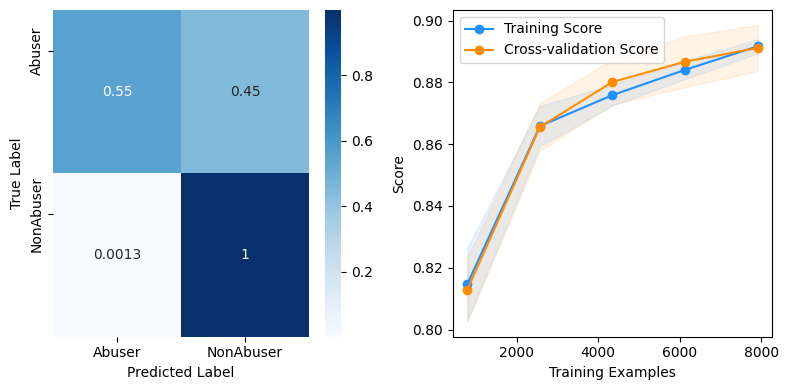

In [111]:
# Support Vector Machine(linear-SVM)
# Before score : 0.7643492320129345
# Best score : 0.9159256265157639
svm = svm.SVC(C=1, gamma=0.1, probability=True, random_state=random_state)
param_grid = tuned_parameters = [
                                {'kernel': ['linear'],
                                  'C': [.1, 1, 10]}
                                ]

svm_pgs = GridSearchCV(estimator=svm,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=False,
                       n_jobs=-1)

best_svc_pgs = svm_pgs.fit(train_X, train_y)
pgs_performance(best_svc_pgs, 'Support Vector Classifier', 'SVC')

svc_prediction = best_svc_pgs.predict(test_X)
print('Accuracy for SVM is ', accuracy_score(svc_prediction, test_y))


 Logistic Regression
-------------------------------
   Best Score (recall): 0.985
   Best Parameters: 
      max_iter: 100
      penalty: l2
      solver: lbfgs
The accuracy of the Logistic Regression is 0.9078415521422797


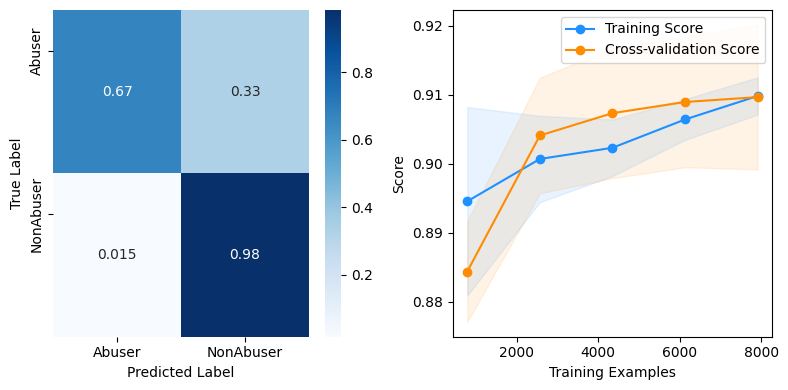

In [121]:
# Logistic Regression
# Before score : 0.8058045241143833
# Best score : 0.9078415521422797
lr = LogisticRegression(random_state=random_state)

param_grid = {
    'max_iter': [100],
    'penalty': ['l1', 'l2'],
    'solver': ['lbfgs']
}

lr_pgs = GridSearchCV(estimator=lr,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=False,
                      n_jobs=-1)

best_lr_pgs = lr_pgs.fit(train_X, train_y)
pgs_performance(best_lr_pgs, 'Logistic Regression', 'LR')

lr_prediction = best_lr_pgs.predict(test_X)
print('The accuracy of the Logistic Regression is', accuracy_score(lr_prediction, test_y))


 Decision Tree
-------------------------------
   Best Score (recall): 0.994
   Best Parameters: 
      max_depth: 3
      min_samples_leaf: 3
      min_samples_split: 2
The accuracy of the Decision Tree is 0.8831851253031527


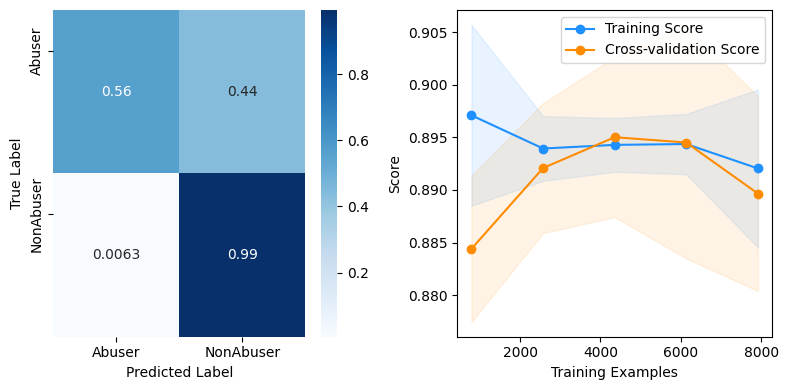

In [38]:
# Decision Tree
# Before score : 0.8548868971404183
# Best score : 0.9183508488278093
dt = DecisionTreeClassifier(random_state=random_state)

param_grid ={
    "min_samples_leaf":[1, 2, 3, 4, 5, 6, 7, 8, 9],
    "max_depth":[2, 3, 4, 5, 6, None],
    "min_samples_split":[2, 3, 4, 5, 6, 7, 8, 9, 10]
}

dt_pgs = GridSearchCV(estimator=dt,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=False,
                      n_jobs=-1)

best_dt_pgs = dt_pgs.fit(train_X, train_y)
pgs_performance(best_dt_pgs, 'Decision Tree', 'DT')

dt_prediction = best_dt_pgs.predict(test_X)
print('The accuracy of the Decision Tree is', accuracy_score(dt_prediction, test_y))


 K-Nearest Neighbors
-------------------------------
   Best Score (recall): 0.996
   Best Parameters: 
      metric: euclidean
      n_neighbors: 19
      weights: distance
The accuracy of the KNN is 0.9219886822958772


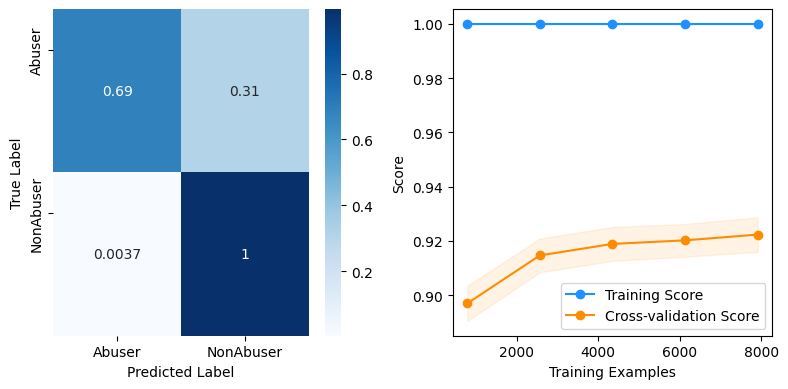

In [39]:
# K-Nearest Neighbors(KNN)
# Before score : 0.9023687580025608
# Best score : 0.9300727566693614
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors' : list(range(1, 20)),
    'weights' : ["uniform", "distance"],
    'metric' : ['euclidean', 'manhattan', 'minkowski']
}

knn_pgs = GridSearchCV(estimator=knn,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=False,
                      n_jobs=-1)

best_knn_pgs = knn_pgs.fit(train_X, train_y)
pgs_performance(best_knn_pgs, 'K-Nearest Neighbors', 'KNN')

knn_prediction = best_knn_pgs.predict(test_X)
print('The accuracy of the KNN is', accuracy_score(knn_prediction, test_y))


 Random Forest
-------------------------------
   Best Score (recall): 0.996
   Best Parameters: 
      bootstrap: False
      criterion: entropy
      max_depth: 6
      max_features: auto
      min_samples_leaf: 2
      min_samples_split: 2
      n_estimators: 100
The accuracy of the Random Forests is 0.9187550525464834


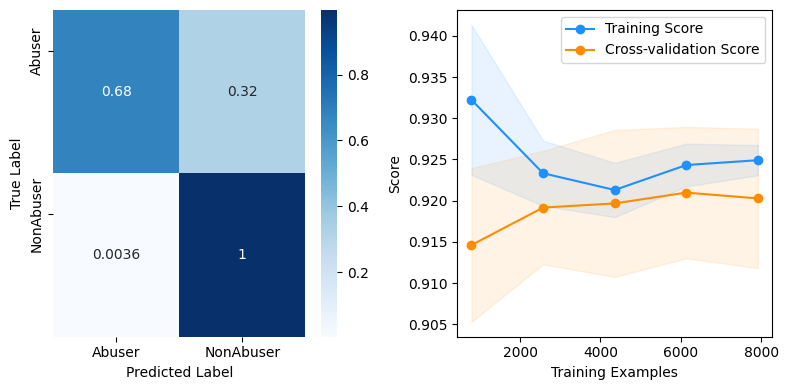

In [40]:
# Random Forest
# Before score : 0.852112676056338
# Best score : 0.931285367825384
rf = RandomForestClassifier(random_state=random_state)

param_grid = {
    'n_estimators': [100],
    'criterion': ['entropy', 'gini'],
    'bootstrap': [True, False],
    'max_depth': [6],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [2, 3, 5],
    'min_samples_split': [2, 3, 5]
}

rf_pgs = GridSearchCV(estimator=rf,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=False,
                      n_jobs=-1)

best_rf_pgs = rf_pgs.fit(train_X, train_y)
clf_performance(best_rf_pgs, 'Random Forest', 'RF')

rf_prediction = best_rf_pgs.predict(test_X)
print('The accuracy of the Random Forests is', accuracy_score(rf_prediction, test_y))

[LightGBM] [Info] Number of positive: 7509, number of negative: 2387
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11153
[LightGBM] [Info] Number of data points in the train set: 9896, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.758791 -> initscore=1.146065
[LightGBM] [Info] Start training from score 1.146065

 LGBMClassifier
-------------------------------
   Best Score (recall): 0.99
   Best Parameters: 
      max_depth: 5
      min_child_samples: 10
      n_estimators: 200
      num_leaves: 5
      reg_alpha: 0.5
      reg_lambda: 0.5
[LightGBM] [Info] Number of positive: 6007, number of negative: 1909
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003066 seconds.
You can set `force_row_wise=true` to rem

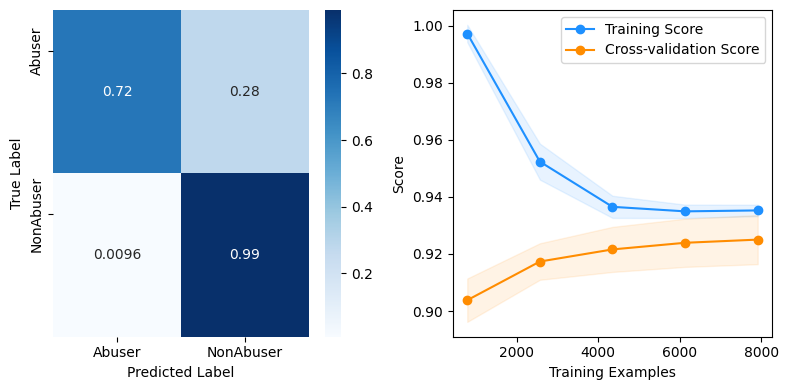

In [133]:
# LGBMClassifier
# Before score : 0.7759282970550576
# Best score : 0.9227970897332255
lgbmc = LGBMClassifier(random_state=random_state)

param_grid = {
    'max_depth': [5],
    'num_leaves': [5, 10],
    'n_estimators': [200],
    'min_child_samples': [5, 10],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [0.1, 0.5]
}

lgbmc_pgs = GridSearchCV(estimator=lgbmc,
                         param_grid=param_grid,
                         scoring=scoring_metric,
                         cv=5,
                         verbose=False,
                         n_jobs=-1)

best_lgbmc_pgs = lgbmc_pgs.fit(train_X, train_y)
pgs_performance(best_lgbmc_pgs, 'LGBMClassifier', 'LGBMC')

lgbmc_prediction = best_lgbmc_pgs.predict(test_X)
print('The accuracy of the LGBMClassifier is', accuracy_score(lgbmc_prediction, test_y))

In [52]:
# Gaussian Naive Bayes
# Before score : 0.8319462227912933
# Best score : 0.881568310428456
gnb = GaussianNB()
gnb.fit(train_X, train_y)
gnb_prediction = gnb.predict(test_X)
print('The accuracy of the Gaussian Naive Bayes is', accuracy_score(gnb_prediction, test_y))

preds = np.array(gnb.predict_proba(test_X))
valid_auc = roc_auc_score(y_score=preds[:,1], y_true=test_y)
print(valid_auc)

The accuracy of the Gaussian Naive Bayes is 0.8726758286176233
0.8593070784971507


In [51]:
# Gradient Boosting Classifier
# Before score : 0.8762270593256509
# Best score : 0.9316895715440582
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=500,random_state=0,learning_rate=0.1)
gb.fit(train_X, train_y)
prediction=gb.predict(test_X)
print('The accuracy for Gradient Boostin is:', accuracy_score(prediction, test_y))

preds = np.array(gb.predict_proba(test_X))
valid_auc = roc_auc_score(y_score=preds[:,1], y_true=test_y)
print(valid_auc)

The accuracy for Gradient Boostin is: 0.917946645109135
0.9518370116226169


In [47]:
# XGBoost Classifier
# Before score : 0.8802816901408451
# Best score : 0.9308811641067097
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=900,learning_rate=0.1)
xgb.fit(train_X, train_y)
prediction = xgb.predict(test_X)
print('The accuracy for XGBoost is:', accuracy_score(prediction, test_y))

preds = np.array(xgb.predict_proba(test_X))
valid_auc = roc_auc_score(y_score=preds[:,1], y_true=test_y)
print(valid_auc)

The accuracy for XGBoost is: 0.9236054971705739
0.9555112101844945


In [50]:
# Bagging Classifier (KNeighborsClassifier)
# Before score : 0.8124199743918054
# Best score : 0.9248181083265966
bc_kn = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=3), random_state=0, n_estimators=700)
bc_kn.fit(train_X, train_y)
prediction = bc_kn.predict(test_X)
print('The accuracy for bagged KNN is:', accuracy_score(prediction, test_y))

preds = np.array(bc_kn.predict_proba(test_X))
valid_auc = roc_auc_score(y_score=preds[:,1], y_true=test_y)
print(valid_auc)

The accuracy for bagged KNN is: 0.9147130153597413
0.9403844518681304


In [49]:
# BaggingClassifier (DecisionTreeClassifier)
# Before score : 0.8781476739223218
# Best score : 0.9296685529506872
bc_dt = BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=0, n_estimators=100)
bc_dt.fit(train_X, train_y)
prediction = bc_dt.predict(test_X)
print('The accuracy for bagged Decision Tree is:', accuracy_score(prediction, test_y))

preds = np.array(bc_dt.predict_proba(test_X))
valid_auc = roc_auc_score(y_score=preds[:,1], y_true=test_y)
print(valid_auc)

The accuracy for bagged Decision Tree is: 0.929264349232013
0.9498410316332586


In [48]:
# AdaBoostClassifier
# Before score : 0.8376013657703798
# Best score : 0.9207760711398545
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.1)
abc.fit(train_X, train_y)
prediction = abc.predict(test_X)
print('The accuracy for AdaBoost is:', accuracy_score(prediction, test_y))

preds = np.array(abc.predict_proba(test_X))
valid_auc = roc_auc_score(y_score=preds[:,1], y_true=test_y)
print(valid_auc)

The accuracy for AdaBoost is: 0.9143088116410671
0.9389179281429673


### 4. Label Propagation

In [53]:
def label_prop(kernel, params_list, X_train, X_test, y_train, y_test):
    n, g = 10, 0
    roc_scores = []
    if kernel == 'rbf':
        for g in params_list:
            lp = LabelPropagation(kernel=kernel, gamma=g, max_iter=100000, tol=0.0001)
            lp.fit(train_X, train_y)
            roc_scores.append(roc_auc_score(test_y, lp.predict_proba(test_X)[:,1]))
    if kernel == 'knn':
        for n in params_list:
            lp = LabelPropagation(kernel=kernel, n_neighbors=n, max_iter=100000, tol=0.0001)
            lp.fit(train_X, train_y)
            roc_scores.append(roc_auc_score(test_y, lp.predict_proba(test_X)[:,1]))

    plt.figure(figsize=(7,3));
    plt.plot(params_list, roc_scores)
    plt.title('Label Propagation ROC AUC with ' + kernel + ' kernel')
    plt.show()
    print('Best metrics value is at {}'.format(params_list[np.argmax(roc_scores)]))

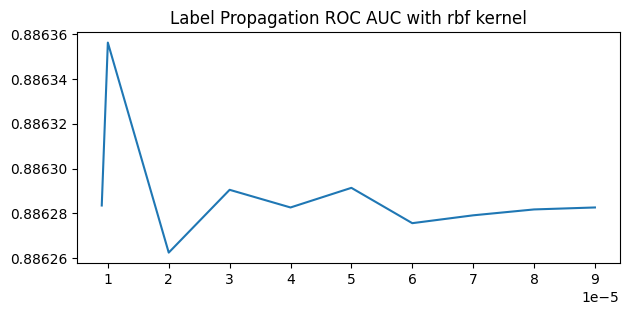

Best metrics value is at 1e-05


In [54]:
gammas = [9e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 6e-5, 7e-5, 8e-5, 9e-5]
label_prop('rbf', gammas, train_X, test_X, train_y, test_y)

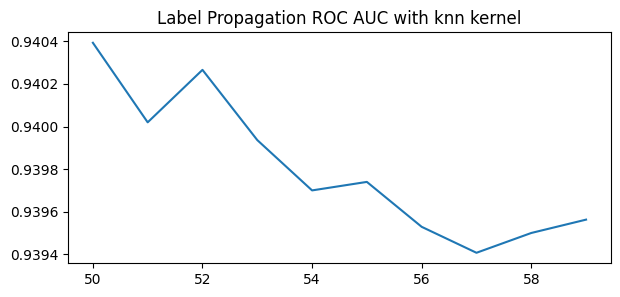

Best metrics value is at 50


In [55]:
ns = np.arange(50,60)
label_prop('knn', ns, train_X, test_X, train_y, test_y)

In [59]:
index = ['Algorithm', 'ROC AUC']
results = pd.DataFrame(columns=index)

lp_rbf = LabelPropagation(kernel='rbf', gamma=1e-05, max_iter=100000, tol=0.0001)
lp_rbf.fit(train_X, train_y)
preds = lp_rbf.predict_proba(test_X)[:,1]
results = results.append(pd.Series(['Label Propagation RBF', roc_auc_score(test_y, preds)], index=index), ignore_index=True)

lp_knn = LabelPropagation(kernel='knn', n_neighbors=50, max_iter=100000, tol=0.0001)
lp_knn.fit(train_X, train_y)
preds = lp_knn.predict_proba(test_X)[:,1]
results = results.append(pd.Series(['Label Propagation KNN', roc_auc_score(test_y, preds)], index=index), ignore_index=True)

results

,Algorithm,ROC AUC
0,Label Propagation RBF,0.886356
1,Label Propagation KNN,0.940393


In [60]:
ls_rbf = LabelSpreading(kernel='rbf', gamma=1e-05, alpha=0.6, max_iter=1000, tol=0.001)
ls_rbf.fit(train_X, train_y)
preds = ls_rbf.predict_proba(test_X)[:,1]
results = results.append(pd.Series(['Label Spreading RBF', roc_auc_score(test_y, preds)], index=index), ignore_index=True)

ls_knn = LabelSpreading(kernel='knn', n_neighbors=50, alpha=0.08, max_iter=1000, tol=0.001)
ls_knn.fit(train_X, train_y)
preds = ls_knn.predict_proba(test_X)[:,1]
results = results.append(pd.Series(['Label Spreading KNN', roc_auc_score(test_y, preds)], index=index), ignore_index=True)

results

,Algorithm,ROC AUC
0,Label Propagation RBF,0.886356
1,Label Propagation KNN,0.940393
2,Label Spreading RBF,0.886356
3,Label Spreading KNN,0.939455


### 5. Self-supervised learning Model

In [61]:
!pip install pytorch-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.2 MB/s eta 0:00:00


In [62]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.metrics import Metric

In [63]:
clf = TabNetClassifier()
clf.fit(
  train_X, train_y,
  eval_set=[(test_X, test_y)]
)
preds = clf.predict(train_X)

epoch 0  | loss: 0.65584 | val_0_auc: 0.80186 |  0:00:01s
epoch 1  | loss: 0.46139 | val_0_auc: 0.85417 |  0:00:01s
epoch 2  | loss: 0.38884 | val_0_auc: 0.85746 |  0:00:02s
epoch 3  | loss: 0.33458 | val_0_auc: 0.87776 |  0:00:03s
epoch 4  | loss: 0.30966 | val_0_auc: 0.87491 |  0:00:04s
epoch 5  | loss: 0.29505 | val_0_auc: 0.89005 |  0:00:05s
epoch 6  | loss: 0.27944 | val_0_auc: 0.88817 |  0:00:06s
epoch 7  | loss: 0.26276 | val_0_auc: 0.86629 |  0:00:06s
epoch 8  | loss: 0.25608 | val_0_auc: 0.85613 |  0:00:07s
epoch 9  | loss: 0.24603 | val_0_auc: 0.88042 |  0:00:07s
epoch 10 | loss: 0.24009 | val_0_auc: 0.89668 |  0:00:08s
epoch 11 | loss: 0.23832 | val_0_auc: 0.89569 |  0:00:09s
epoch 12 | loss: 0.23603 | val_0_auc: 0.88833 |  0:00:09s
epoch 13 | loss: 0.2357  | val_0_auc: 0.87695 |  0:00:10s
epoch 14 | loss: 0.22775 | val_0_auc: 0.89781 |  0:00:10s
epoch 15 | loss: 0.22568 | val_0_auc: 0.90561 |  0:00:11s
epoch 16 | loss: 0.2274  | val_0_auc: 0.9133  |  0:00:11s
epoch 17 | los

In [66]:
# TabNetPretrainer
# Before score : 0.94841
# Best score : 0.95571
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax' # "sparsemax"
)

unsupervised_model.fit(
    X_train=train_X,
    eval_set=[test_X],
    pretraining_ratio=0.8,
)

clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, # how to use learning rate scheduler
                      "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax' # This will be overwritten if using pretrain model
)

clf.fit(
    X_train=train_X, y_train=train_y,
    eval_set=[(train_X, train_y), (test_X, test_y)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    from_unsupervised=unsupervised_model
)

epoch 0  | loss: 37341.63303| val_0_unsup_loss_numpy: 601.8145751953125|  0:00:00s
epoch 1  | loss: 6431.05192| val_0_unsup_loss_numpy: 53.70846176147461|  0:00:01s
epoch 2  | loss: 2108.79733| val_0_unsup_loss_numpy: 42.5088005065918|  0:00:02s
epoch 3  | loss: 322.01492| val_0_unsup_loss_numpy: 47.22724151611328|  0:00:02s
epoch 4  | loss: 154.92385| val_0_unsup_loss_numpy: 62.5844612121582|  0:00:03s
epoch 5  | loss: 58.36586| val_0_unsup_loss_numpy: 6.186779975891113|  0:00:04s
epoch 6  | loss: 35.66656| val_0_unsup_loss_numpy: 6.214590072631836|  0:00:04s
epoch 7  | loss: 10.42942| val_0_unsup_loss_numpy: 4.550099849700928|  0:00:06s
epoch 8  | loss: 6.28707 | val_0_unsup_loss_numpy: 1.6184500455856323|  0:00:06s
epoch 9  | loss: 4.03476 | val_0_unsup_loss_numpy: 1.9410799741744995|  0:00:07s
epoch 10 | loss: 3.5623  | val_0_unsup_loss_numpy: 1.4365099668502808|  0:00:08s
epoch 11 | loss: 2.32282 | val_0_unsup_loss_numpy: 1.4103699922561646|  0:00:08s
epoch 12 | loss: 2.67467 | va

In [67]:
preds = np.array(clf.predict_proba(test_X))
valid_auc = roc_auc_score(y_score=preds[:,1], y_true=test_y)
print(valid_auc)

0.955714139199662


### 6. Semi-supervised learning Model

In [105]:
# Using AutoEncoder
test_ae = pd.read_csv('/content/gdrive/My Drive/data/data.csv')
test_ae = test_ae[test_ae['isAbuser'] == -1]

test_rep_x = hidden_representation.predict(test_x_scale)
test_ae['isAbuser'] = [int(x) for x in clf.predict(test_rep_x)]
test_ae.head()

2775/2775 [==============================] - 4s 2ms/step


,newID,char_jobcode,char_level,logging_timestamp,charStatA,charStatB,charStatC,charStatD,charStatE,charStatF,...,actionSessionAmountH,actionSessionAmountI,actionSessionAmountJ,actionSessionAmountK,actionSessionAmountL,actionSessionAmountM,actionSessionAmountN,tradeSessionAmountD,tradeSessionAmountE,isAbuser
0,0,0,10,2022-06-26 08:59:04,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
1,0,0,31,2022-06-26 09:29:06,0,0,0,0,2,0,...,0,0,0,2,146,0,106,0,0,0
2,0,0,40,2022-06-26 09:59:13,0,0,0,0,2,0,...,0,0,0,2,229,0,172,0,0,0
3,0,0,61,2022-06-26 10:29:14,0,0,0,0,6,0,...,1,2,0,2,583,0,615,0,0,0
4,0,0,61,2022-06-27 07:51:56,0,0,0,0,6,0,...,0,1,0,17,1,0,0,0,0,1


### 7. Feature importance

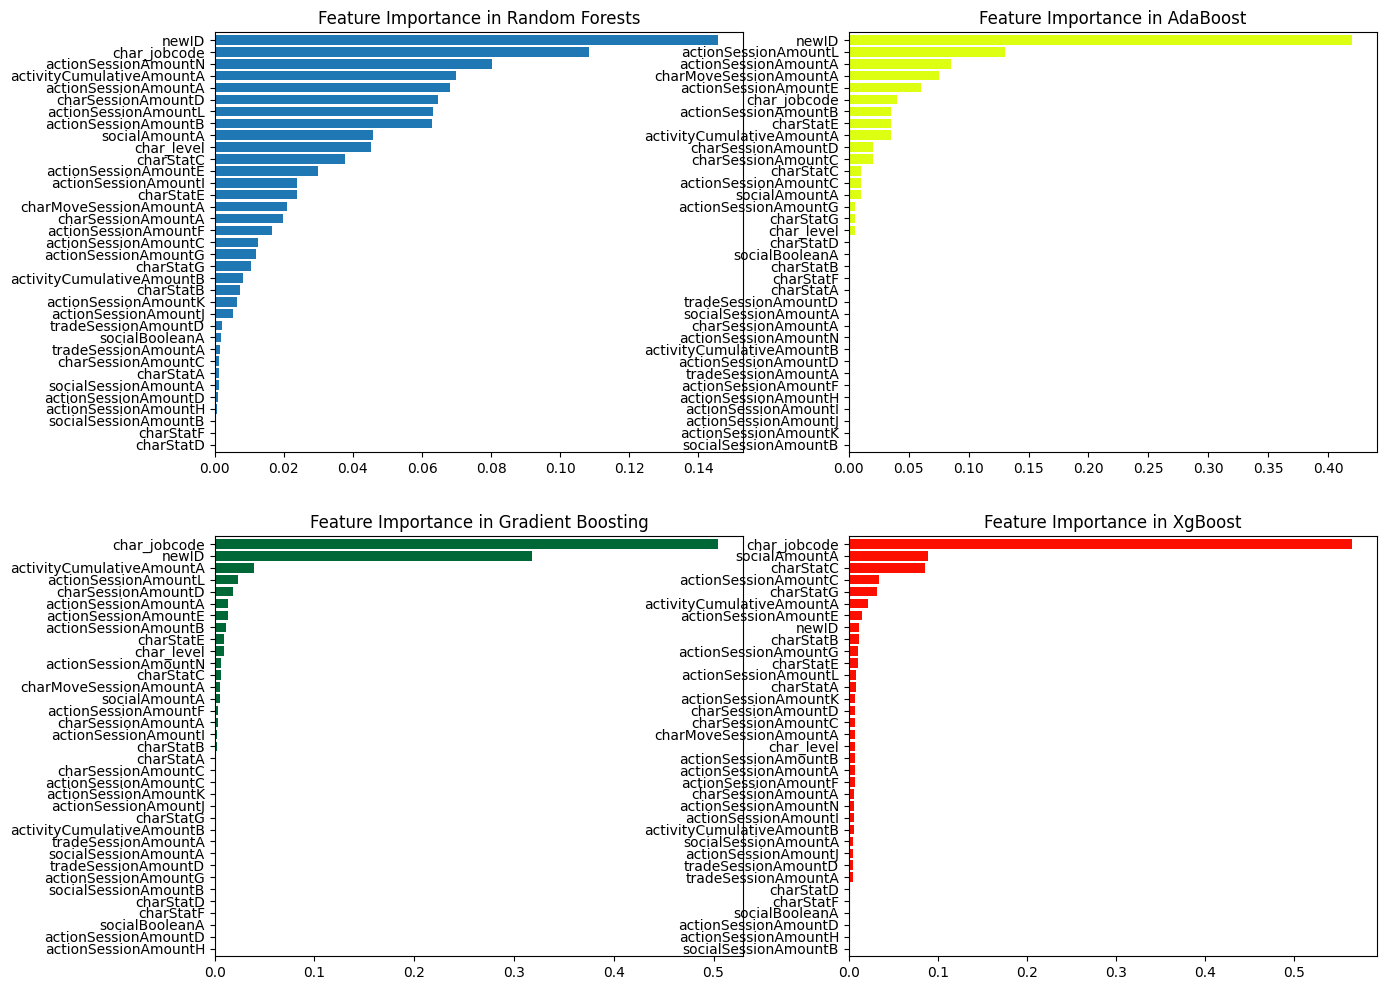

In [136]:
# Feature Importance
f,ax=plt.subplots(2,2,figsize=(15,12))
model=RandomForestClassifier(n_estimators=100,random_state=0)
model.fit(x,y)
pd.Series(model.feature_importances_,x.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,0])
ax[0,0].set_title('Feature Importance in Random Forests')
model=AdaBoostClassifier(n_estimators=200,learning_rate=0.1,random_state=0)
model.fit(x,y)
pd.Series(model.feature_importances_,x.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,1],color='#ddff11')
ax[0,1].set_title('Feature Importance in AdaBoost')
model=GradientBoostingClassifier(n_estimators=500,learning_rate=0.1,random_state=0)
model.fit(x,y)
pd.Series(model.feature_importances_,x.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,0],cmap='RdYlGn_r')
ax[1,0].set_title('Feature Importance in Gradient Boosting')
model=xg.XGBClassifier(n_estimators=900,learning_rate=0.1)
model.fit(x,y)
pd.Series(model.feature_importances_,x.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,1],color='#FD0F00')
ax[1,1].set_title('Feature Importance in XgBoost')
plt.show()

### 8. Prediction

In [134]:
comparison_matrix = {}
for key, value in comparison_dict.items():
    comparison_matrix[str(key)] = value[0:4]

comparison_df = pd.DataFrame(comparison_matrix,
                             index=['Accuracy', 'Precision', 'Recall', 'AUC']).T
comparison_df.style.highlight_max(color='indianred', axis=0)

,Accuracy,Precision,Recall,AUC
LR,0.909660,0.904785,0.984552,0.829310
DT,0.889652,0.877160,0.993741,0.777976
KNN,0.922292,0.909876,0.996271,0.842920
RF,0.920271,0.907569,0.996404,0.838588
LGBMC,0.926031,0.918488,0.990412,0.856957
SVC,0.891168,0.875438,0.998668,0.775832


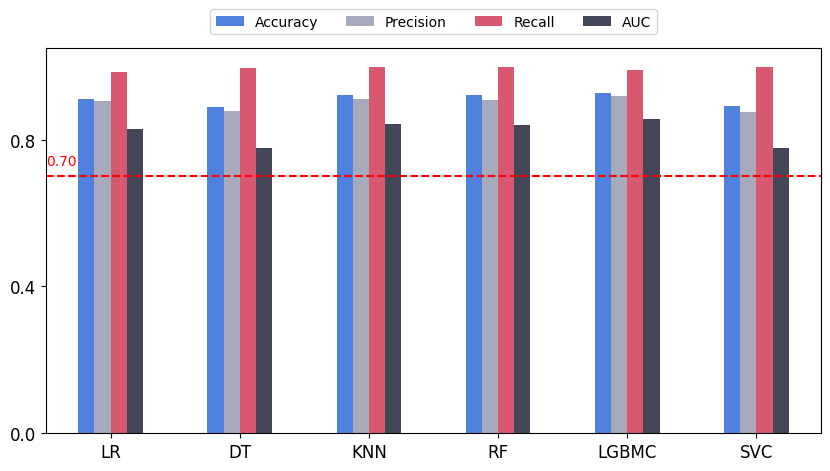

In [135]:
comparison_df.plot(kind='bar',
                   figsize=(10, 5),
                   fontsize=12,
                   color=['#5081DE', '#A7AABD', '#D85870', '#424656'])

plt.legend(loc='upper center',
           ncol=len(comparison_df.columns),
           bbox_to_anchor=(0.5, 1.12))
plt.xticks(rotation=0)
plt.yticks([0, 0.4, 0.8])

plt.axhline(y=0.70, color='red', linestyle='--')
plt.text(x=-0.5, y=0.73, s='0.70', color='red');

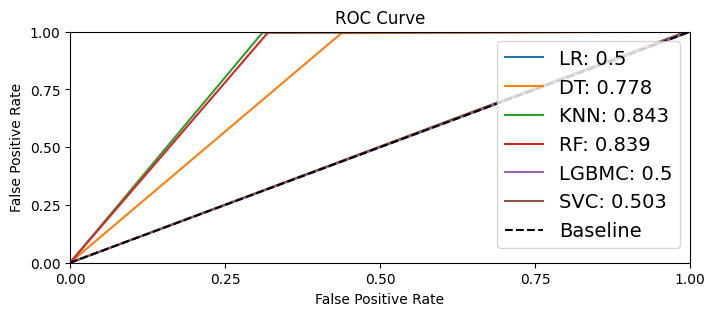

In [58]:
fig, ax = plt.subplots(figsize=(8, 3))

for index, key in enumerate(comparison_dict.keys()):
    auc, fpr, tpr = comparison_dict[key][3], comparison_dict[key][4], comparison_dict[key][5]
    ax.plot(fpr,
            tpr,
            label='{}: {}'.format(key, np.round(auc, 3)))

ax.plot([0, 1], [0, 1], 'k--', label='Baseline')

ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_ylabel('False Positive Rate')
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.autoscale(axis='both', tight=True)
ax.legend(fontsize=14);